# ARIMA-GARCH

In [6]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

data = yf.download("MARA", start="2015-01-01")
data.index = pd.to_datetime(data.index)
data = data.asfreq('B')  # 'B' indicates business days
data = data.ffill().dropna()  # Forward fill NaN values and drop remaining NaNs

[*********************100%%**********************]  1 of 1 completed


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2723.378, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2724.700, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2726.606, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2726.590, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2721.440, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2725.402, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2720.788, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2721.472, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2725.789, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2714.785, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2720.283, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2720.284, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2714.378, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2717.869, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept

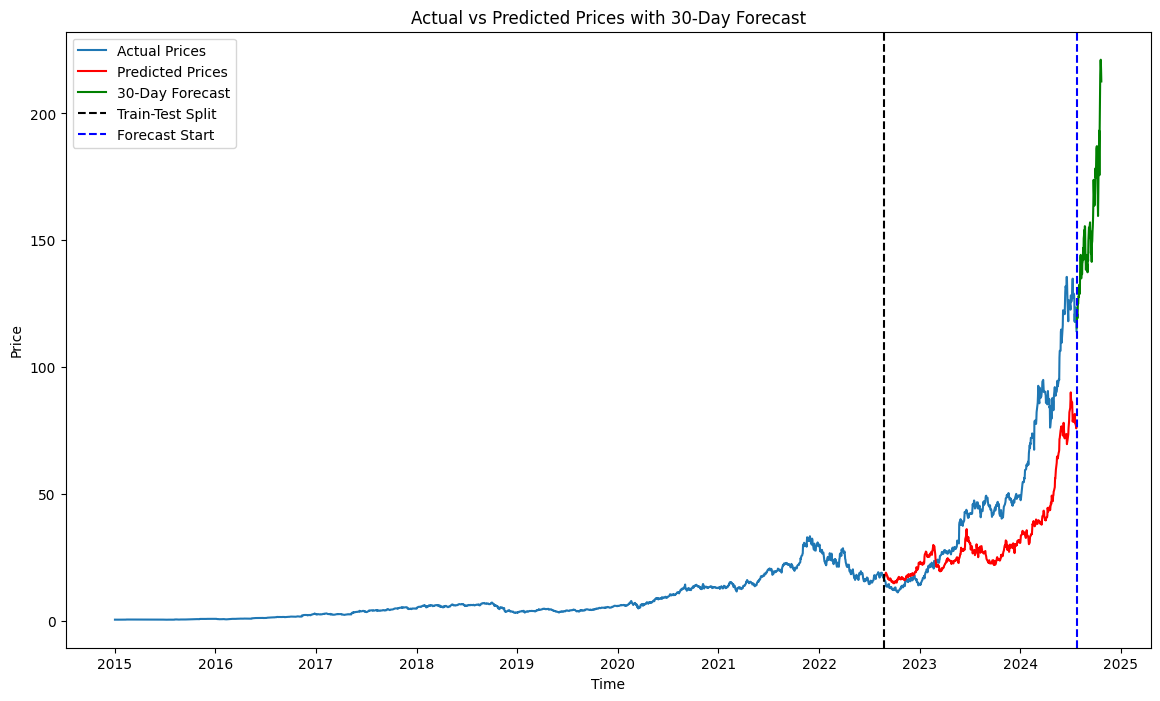

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from arch import arch_model
import statsmodels.api as sm

# Set random seed for reproducibility
np.random.seed(42)

# Extract the closing prices
closing_prices = data['Close']

# Compute Returns
returns = closing_prices.pct_change().dropna()

# Scale Returns
scaled_returns = returns * 100

# Focus on the most recent 1-2 years for validation
recent_years = 2
recent_data_cutoff = closing_prices.index[-1] - pd.DateOffset(years=recent_years)
recent_returns = scaled_returns[scaled_returns.index >= recent_data_cutoff]

# Train-Test Split for the entire dataset
train_size = int(len(scaled_returns) * 0.8)
train_returns, test_returns = scaled_returns[:train_size], scaled_returns[train_size:]

# Further split the training data for validation
validation_size = int(len(train_returns) * 0.2)
train_returns, validation_returns = train_returns[:-validation_size], train_returns[-validation_size:]

# Convert train_returns to a DataFrame and rename column for consistency
train_returns = pd.DataFrame(train_returns)
train_returns.rename(columns={train_returns.columns[0]: 'Log Return Rate'}, inplace=True)

# Determine the ARIMA Order using pmdarima on recent data
arima_model = pm.auto_arima(recent_returns, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
order = arima_model.order

# Fit ARIMA Model on Returns using the determined order
arma_mod01 = sm.tsa.ARIMA(train_returns, order=order).fit()

# Function to fit GARCH model and find the best parameters using validation set
def fit_garch_model(train_returns, validation_returns):
    best_aic = np.inf
    best_params = None
    for p in range(1, 3):
        for q in range(1, 3):
            model = arch_model(train_returns, vol='Garch', p=p, q=q, dist='StudentsT')
            res = model.fit(update_freq=5, disp='off')
            if res.aic < best_aic:
                best_aic = res.aic
                best_params = (p, q)
    final_model = arch_model(train_returns, vol='Garch', p=best_params[0], q=best_params[1], dist='StudentsT')
    final_res = final_model.fit(update_freq=5, disp='off')
    return final_res

# Fit GARCH Model on the training data
res = fit_garch_model(train_returns, validation_returns)

# Extract parameters
mu = arma_mod01.params['const']
if 'ar.L1' in arma_mod01.params:
    theta = arma_mod01.params['ar.L1']
else:
    theta = 0
omega = res.params['omega']
alpha = res.params['alpha[1]']
beta = res.params['beta[1]']

# Define the returns_predict Function with dynamic adjustment
def returns_predict(period):
    returns_pool = []
    sigma_t = res.conditional_volatility.iloc[-1]
    
    for i in range(period):
        epsilon_t = sigma_t * np.random.standard_normal()
        sigma_forecast = np.sqrt(omega + alpha * epsilon_t ** 2 + beta * sigma_t ** 2)
        
        # Cap sigma_forecast to avoid extreme values
        sigma_forecast = np.clip(sigma_forecast, 1e-8, 10)
        
        epsilon_forecast = sigma_forecast * np.random.standard_normal()
        returns_forecast = mu + epsilon_forecast + theta * epsilon_t
        
        # Cap returns_forecast to avoid extreme values
        returns_forecast = np.clip(returns_forecast, -10, 10)
        
        returns_pool.append(returns_forecast)
        
        # Update sigma_t
        sigma_t = sigma_forecast
        if not np.isfinite(sigma_t):
            sigma_t = res.conditional_volatility.mean()  # reset to a mean value to avoid instability
    
    return returns_pool

# Generate predictions for the test period
predicted_returns = returns_predict(len(test_returns))

# Convert the predicted returns to a DataFrame
predicted_returns_df = pd.DataFrame(predicted_returns, index=test_returns.index, columns=['Predicted Returns'])

# Ensure that the lengths of the indices match
test_returns = test_returns.iloc[:len(predicted_returns_df)]

# Reconstruct the actual prices from the predicted returns
initial_price = closing_prices.iloc[train_size - 1]
predicted_prices = initial_price * np.exp(predicted_returns_df.cumsum() / 100)

# Generate predictions for the next 30 days
forecast_period = 90
new_predicted_returns = returns_predict(forecast_period)

# Convert the predicted returns to a DataFrame
last_date = closing_prices.index[-1]
new_predicted_dates = pd.date_range(last_date + pd.DateOffset(1), periods=forecast_period)
new_predicted_returns_df = pd.DataFrame(new_predicted_returns, index=new_predicted_dates, columns=['Predicted Returns'])

# Reconstruct the actual prices from the predicted returns
new_initial_price = closing_prices.iloc[-1]
new_predicted_prices = new_initial_price * np.exp(new_predicted_returns_df.cumsum() / 100)

# Plot the real vs predicted prices including the forecast for the next 30 days
plt.figure(figsize=(14, 8))
plt.plot(closing_prices.index, closing_prices, label='Actual Prices')
plt.plot(predicted_prices.index, predicted_prices, label='Predicted Prices', color='red')
plt.plot(new_predicted_prices.index, new_predicted_prices, label='30-Day Forecast', color='green')
plt.axvline(x=closing_prices.index[train_size], color='black', linestyle='--', label='Train-Test Split')
plt.axvline(x=new_predicted_prices.index[0], color='blue', linestyle='--', label='Forecast Start')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices with 30-Day Forecast')
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2723.378, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2724.700, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2726.606, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2726.590, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2721.440, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2725.402, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2720.788, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2721.472, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2725.789, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2714.785, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2720.283, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2720.284, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2714.378, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2717.869, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept

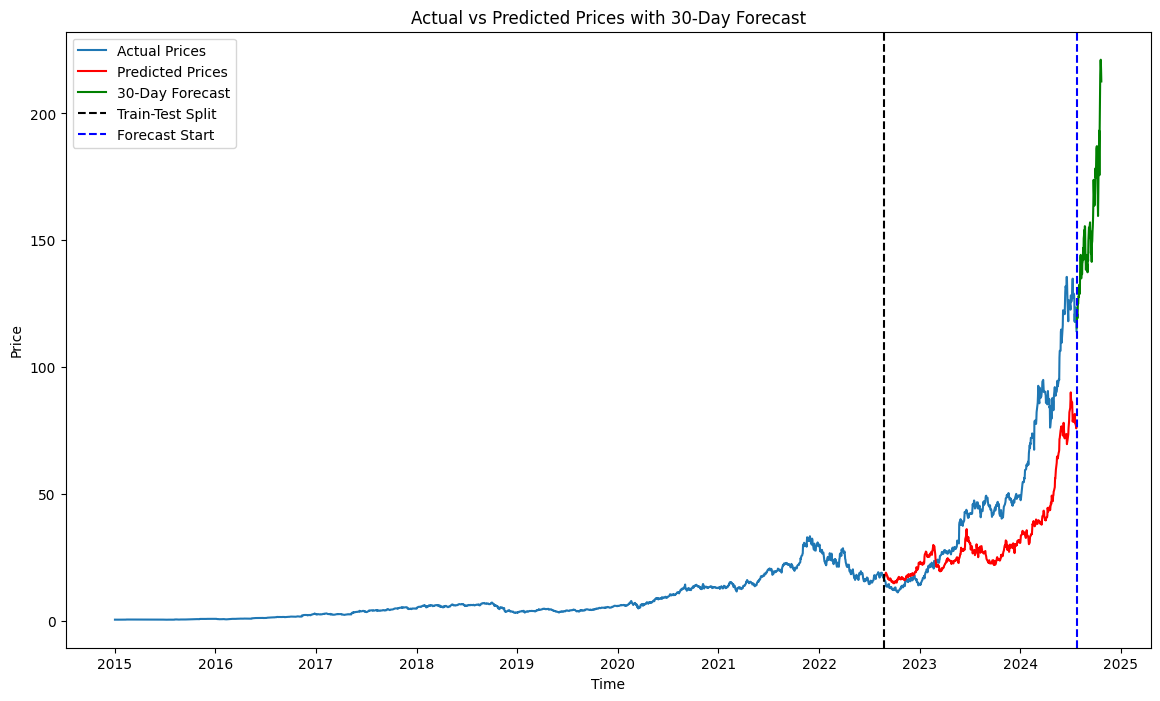

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from arch import arch_model
import statsmodels.api as sm

# Set random seed for reproducibility
np.random.seed(42)

# Extract the closing prices
closing_prices = data['Close']

# Compute Returns
returns = closing_prices.pct_change().dropna()

# Scale Returns
scaled_returns = returns * 100

# Focus on the most recent 1-2 years for validation
recent_years = 2
recent_data_cutoff = closing_prices.index[-1] - pd.DateOffset(years=recent_years)
recent_returns = scaled_returns[scaled_returns.index >= recent_data_cutoff]

# Train-Test Split for the entire dataset
train_size = int(len(scaled_returns) * 0.8)
train_returns, test_returns = scaled_returns[:train_size], scaled_returns[train_size:]

# Further split the training data for validation
validation_size = int(len(train_returns) * 0.2)
train_returns, validation_returns = train_returns[:-validation_size], train_returns[-validation_size:]

# Convert train_returns to a DataFrame and rename column for consistency
train_returns = pd.DataFrame(train_returns)
train_returns.rename(columns={train_returns.columns[0]: 'Log Return Rate'}, inplace=True)

# Determine the ARIMA Order using pmdarima on recent data
arima_model = pm.auto_arima(recent_returns, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
order = arima_model.order

# Fit ARIMA Model on Returns using the determined order
arma_mod01 = sm.tsa.ARIMA(train_returns, order=order).fit()

# Function to fit GARCH model and find the best parameters using validation set
def fit_garch_model(train_returns, validation_returns):
    best_aic = np.inf
    best_params = None
    for p in range(1, 3):
        for q in range(1, 3):
            model = arch_model(train_returns, vol='Garch', p=p, q=q, dist='StudentsT')
            res = model.fit(update_freq=5, disp='off')
            if res.aic < best_aic:
                best_aic = res.aic
                best_params = (p, q)
    final_model = arch_model(train_returns, vol='Garch', p=best_params[0], q=best_params[1], dist='StudentsT')
    final_res = final_model.fit(update_freq=5, disp='off')
    return final_res

# Fit GARCH Model on the training data
res = fit_garch_model(train_returns, validation_returns)

# Extract parameters
mu = arma_mod01.params['const']
if 'ar.L1' in arma_mod01.params:
    theta = arma_mod01.params['ar.L1']
else:
    theta = 0
omega = res.params['omega']
alpha = res.params['alpha[1]']
beta = res.params['beta[1]']

# Define the returns_predict Function with dynamic adjustment
def returns_predict(period):
    returns_pool = []
    sigma_t = res.conditional_volatility.iloc[-1]
    
    for i in range(period):
        epsilon_t = sigma_t * np.random.standard_normal()
        sigma_forecast = np.sqrt(omega + alpha * epsilon_t ** 2 + beta * sigma_t ** 2)
        
        # Cap sigma_forecast to avoid extreme values
        sigma_forecast = np.clip(sigma_forecast, 1e-8, 10)
        
        epsilon_forecast = sigma_forecast * np.random.standard_normal()
        returns_forecast = mu + epsilon_forecast + theta * epsilon_t
        
        # Cap returns_forecast to avoid extreme values
        returns_forecast = np.clip(returns_forecast, -10, 10)
        
        returns_pool.append(returns_forecast)
        
        # Update sigma_t
        sigma_t = sigma_forecast
        if not np.isfinite(sigma_t):
            sigma_t = res.conditional_volatility.mean()  # reset to a mean value to avoid instability
    
    return returns_pool

# Generate predictions for the test period
predicted_returns = returns_predict(len(test_returns))

# Convert the predicted returns to a DataFrame
predicted_returns_df = pd.DataFrame(predicted_returns, index=test_returns.index, columns=['Predicted Returns'])

# Ensure that the lengths of the indices match
test_returns = test_returns.iloc[:len(predicted_returns_df)]

# Reconstruct the actual prices from the predicted returns
initial_price = closing_prices.iloc[train_size - 1]
predicted_prices = initial_price * np.exp(predicted_returns_df.cumsum() / 100)

# Generate predictions for the next 30 days
forecast_period = 90
new_predicted_returns = returns_predict(forecast_period)

# Convert the predicted returns to a DataFrame
last_date = closing_prices.index[-1]
new_predicted_dates = pd.date_range(last_date + pd.DateOffset(1), periods=forecast_period)
new_predicted_returns_df = pd.DataFrame(new_predicted_returns, index=new_predicted_dates, columns=['Predicted Returns'])

# Reconstruct the actual prices from the predicted returns
new_initial_price = closing_prices.iloc[-1]
new_predicted_prices = new_initial_price * np.exp(new_predicted_returns_df.cumsum() / 100)

# Plot the real vs predicted prices including the forecast for the next 30 days
plt.figure(figsize=(14, 8))
plt.plot(closing_prices.index, closing_prices, label='Actual Prices')
plt.plot(predicted_prices.index, predicted_prices, label='Predicted Prices', color='red')
plt.plot(new_predicted_prices.index, new_predicted_prices, label='30-Day Forecast', color='green')
plt.axvline(x=closing_prices.index[train_size], color='black', linestyle='--', label='Train-Test Split')
plt.axvline(x=new_predicted_prices.index[0], color='blue', linestyle='--', label='Forecast Start')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices with 30-Day Forecast')
plt.show()


# PROPHET

DEBUG:cmdstanpy:input tempfile: /var/folders/ps/6sp6yv3x0ls96dst6g5f8sn00000gp/T/tmp_1q1_kb0/oqg4_wtm.json
DEBUG:cmdstanpy:input tempfile: /var/folders/ps/6sp6yv3x0ls96dst6g5f8sn00000gp/T/tmp_1q1_kb0/a7luuh8j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/homebrew/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91779', 'data', 'file=/var/folders/ps/6sp6yv3x0ls96dst6g5f8sn00000gp/T/tmp_1q1_kb0/oqg4_wtm.json', 'init=/var/folders/ps/6sp6yv3x0ls96dst6g5f8sn00000gp/T/tmp_1q1_kb0/a7luuh8j.json', 'output', 'file=/var/folders/ps/6sp6yv3x0ls96dst6g5f8sn00000gp/T/tmp_1q1_kb0/prophet_modelt3mrr1v_/prophet_model-20240629230840.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:08:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:08:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/opt/homebrew/lib/p

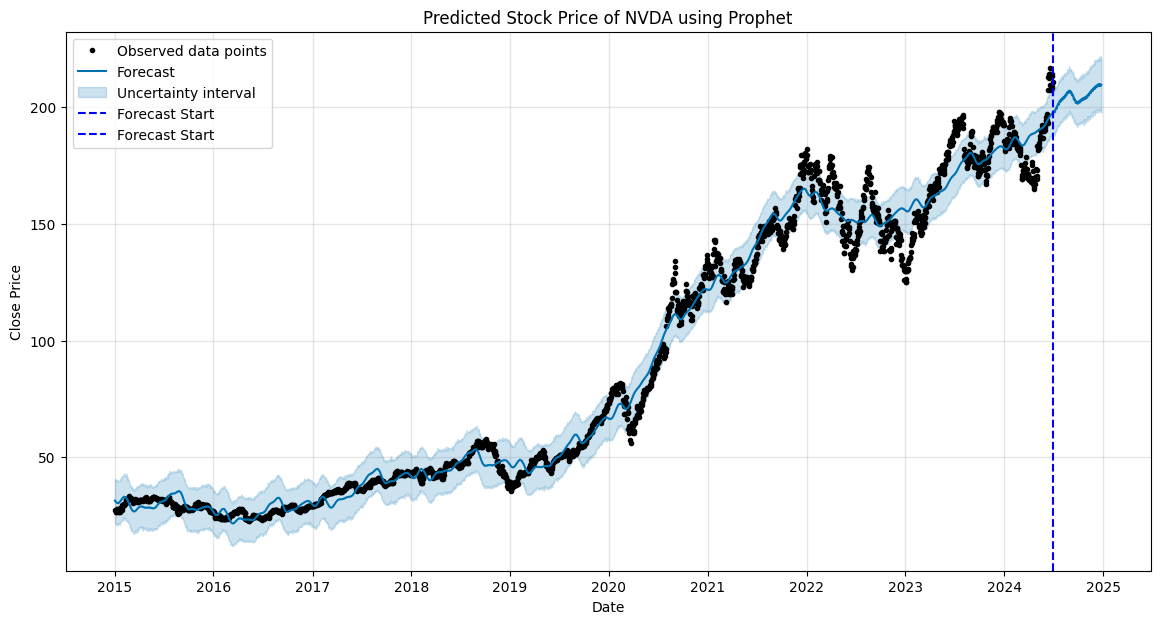

In [43]:
from models.prophet_model import Prophet

# Prepare the Data for Prophet
data_prophet = data.reset_index()
data_prophet = data_prophet.rename(columns={'Date': 'ds', 'Close': 'y'})

# Create and fit Prophet model
model = Prophet(daily_seasonality=True)
model.fit(data_prophet)

# Create future dataframe for the next 3 months (90 days)
future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)

# Plot predictions
fig, ax = plt.subplots(figsize=(14, 7))
model.plot(forecast, ax=ax)
ax.set_title("Predicted Stock Price of NVDA using Prophet")
ax.set_xlabel("Date")
ax.set_ylabel("Close Price")

# Add vertical line for forecast start
forecast_start_date = data_prophet['ds'].iloc[-1]
ax.axvline(x=forecast_start_date, color='blue', linestyle='--', label='Forecast Start')

# Manually add legend for forecast start
handles, labels = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='blue', linestyle='--'))
labels.append('Forecast Start')
ax.legend(handles=handles, labels=labels)

plt.show()


# LSTM

Training model with 50 units, 0.2 dropout, 16 batch size, 50 epochs


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE: 2.0223264179754126
Training model with 50 units, 0.2 dropout, 16 batch size, 100 epochs


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE: 1.6505665883426803
Training model with 50 units, 0.2 dropout, 32 batch size, 50 epochs


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE: 2.206999056083305
Training model with 50 units, 0.2 dropout, 32 batch size, 100 epochs


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE: 1.9009278861629622
Training model with 50 units, 0.3 dropout, 16 batch size, 50 epochs


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE: 2.6805009454474544
Training model with 50 units, 0.3 dropout, 16 batch size, 100 epochs


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE: 2.2408303158857787
Training model with 50 units, 0.3 dropout, 32 batch size, 50 epochs


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
RMSE: 2.276750811667813
Training model with 50 units, 0.3 dropout, 32 batch size, 100 epochs


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE: 1.9131388593544991
Training model with 100 units, 0.2 dropout, 16 batch size, 50 epochs


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
RMSE: 3.1663573655262125
Training model with 100 units, 0.2 dropout, 16 batch size, 100 epochs


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
RMSE: 1.4139197136048938
Training model with 100 units, 0.2 dropout, 32 batch size, 50 epochs


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
RMSE: 2.370234868378087
Training model with 100 units, 0.2 dropout, 32 batch size, 100 epochs


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
RMSE: 1.6766639279433282
Training model with 100 units, 0.3 dropout, 16 batch size, 50 epochs


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
RMSE: 2.3754957462951425
Training model with 100 units, 0.3 dropout, 16 batch size, 100 epochs


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
RMSE: 3.0483141015598374
Training model with 100 units, 0.3 dropout, 32 batch size, 50 epochs


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
RMSE: 1.9635148429283138
Training model with 100 units, 0.3 dropout, 32 batch size, 100 epochs


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
RMSE: 3.5192549364200367
Best RMSE: 1.4139197136048938
Best Parameters: {'units': 100, 'dropout': 0.2, 'batch_size': 16, 'epochs': 100}
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


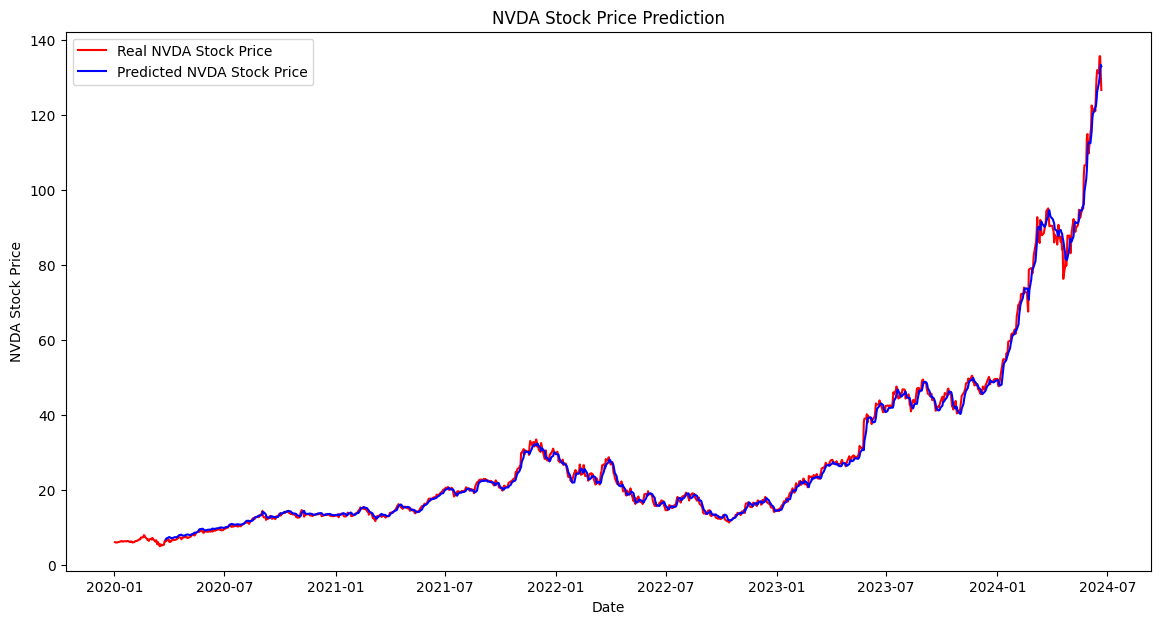

In [39]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

closing_prices = data['Close'].values.reshape(-1, 1)

# Feature Scaling
sc = MinMaxScaler(feature_range=(0, 1))
scaled_prices = sc.fit_transform(closing_prices)

# Creating a data structure with 60 time-steps and 1 output
lookback_period = 60
X = []
y = []
for i in range(lookback_period, len(scaled_prices)):
    X.append(scaled_prices[i-lookback_period:i, 0])
    y.append(scaled_prices[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Hyperparameters to try
units_list = [50, 100]
dropout_list = [0.2, 0.3]
batch_size_list = [16, 32]
epoch_list = [50, 100]

# Function to build the model
def build_model(units, dropout):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Cross-validation to find the best model
best_rmse = float('inf')
best_params = {}
best_model = None

for units in units_list:
    for dropout in dropout_list:
        for batch_size in batch_size_list:
            for epochs in epoch_list:
                print(f"Training model with {units} units, {dropout} dropout, {batch_size} batch size, {epochs} epochs")
                
                # Build and train the model
                model = build_model(units, dropout)
                model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)
                
                # Predict and calculate RMSE
                predicted_stock_price = model.predict(X)
                predicted_stock_price = sc.inverse_transform(predicted_stock_price)
                real_stock_price = sc.inverse_transform(y.reshape(-1, 1))
                
                rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
                print(f"RMSE: {rmse}")

                # Update the best model
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = {
                        'units': units,
                        'dropout': dropout,
                        'batch_size': batch_size,
                        'epochs': epochs
                    }
                    best_model = model

print(f"Best RMSE: {best_rmse}")
print(f"Best Parameters: {best_params}")

# Predicting the stock prices with the best model
predicted_stock_price = best_model.predict(X)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Visualising the results
plt.figure(figsize=(14, 7))
plt.plot(data.index, closing_prices, color='red', label='Real NVDA Stock Price')
plt.plot(data.index[lookback_period:], predicted_stock_price, color='blue', label='Predicted NVDA Stock Price')
plt.title('NVDA Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('NVDA Stock Price')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed


Is the series stationary? No
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━

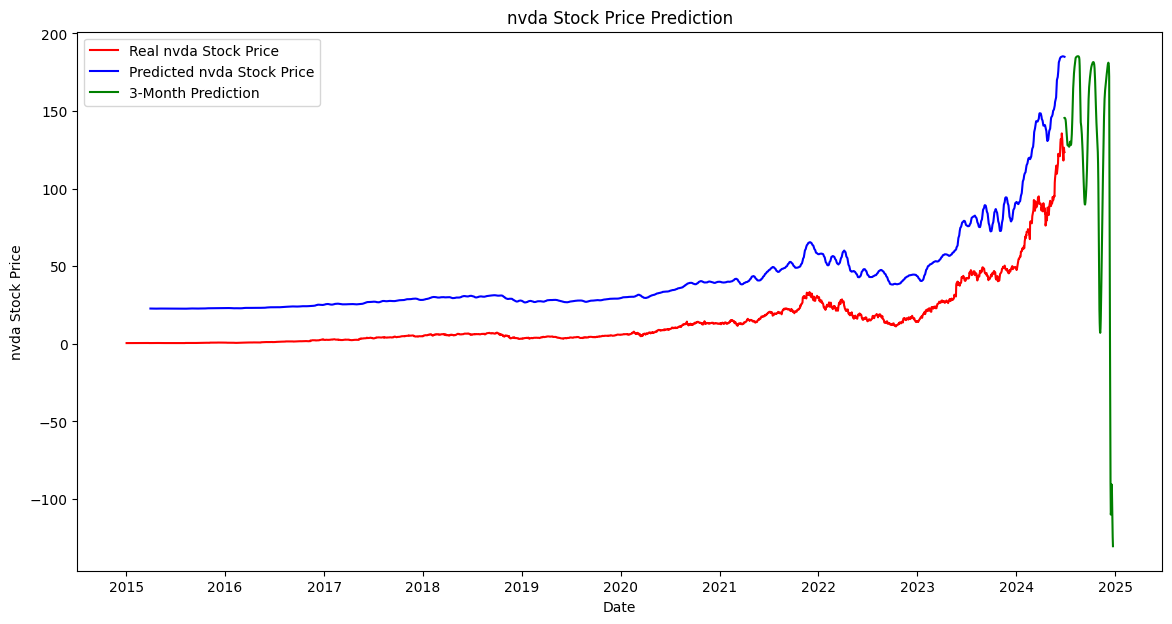

RMSE: 27.72452132029059


In [84]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pickle

def load_data(ticker, start_date):
    data = yf.download(ticker, start=start_date)
    data.index = pd.to_datetime(data.index)
    closing_prices = data['Close'].values.reshape(-1, 1)
    return data, closing_prices

def check_stationarity(data, threshold=0.05):
    result = adfuller(data)
    p_value = result[1]
    return p_value < threshold

def difference_data(data, interval=1):
    diff = []
    for i in range(interval, len(data)):
        diff.append(data[i] - data[i - interval])
    return np.array(diff)

def inverse_difference(last_ob, value):
    return value + last_ob

def create_lagged_features(data, lookback_period):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lookback_period+1)]
    df_lagged = pd.concat(columns, axis=1)
    df_lagged.columns = ['lag_{}'.format(i) for i in range(1, lookback_period+1)]
    df_lagged.dropna(inplace=True)
    return df_lagged.values

def preprocess_data(closing_prices, lookback_period, stationary=False):
    if stationary:
        closing_prices = difference_data(closing_prices.flatten())
        closing_prices = closing_prices.reshape(-1, 1)

    sc = MinMaxScaler(feature_range=(0, 1))
    scaled_prices = sc.fit_transform(closing_prices)
    
    lagged_features = create_lagged_features(scaled_prices, lookback_period)
    X, y = lagged_features, scaled_prices[lookback_period:]
    
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, sc, scaled_prices

def build_model(input_shape, units, dropout):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_model(model, X, y, batch_size, epochs):
    model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.1)
    return model

def predict_future(model, sc, lookback_period, scaled_prices, forecast_days):
    future_predictions = []
    last_lookback_period = scaled_prices[-lookback_period:]
    current_input = last_lookback_period.reshape((1, lookback_period, 1))

    for _ in range(forecast_days):
        future_price = model.predict(current_input)
        future_predictions.append(future_price[0, 0])
        current_input = np.append(current_input[:, 1:, :], future_price.reshape(1, 1, 1), axis=1)

    future_predictions = sc.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_predictions

def plot_predictions(data, closing_prices, predicted_stock_price, future_predictions, ticker):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, closing_prices, color='red', label=f'Real {ticker} Stock Price')
    plt.plot(data.index[lookback_period:], predicted_stock_price, color='blue', label=f'Predicted {ticker} Stock Price')
    plt.plot(pd.date_range(start=data.index[-1], periods=len(future_predictions)), future_predictions, color='green', label='3-Month Prediction')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel(f'{ticker} Stock Price')
    plt.legend()
    plt.show()

def main(ticker, start_date, lookback_period, units, dropout, batch_size, epochs, forecast_days):
    data, closing_prices = load_data(ticker, start_date)
    
    # Check for stationarity
    stationary = check_stationarity(closing_prices.flatten())
    print(f"Is the series stationary? {'Yes' if stationary else 'No'}")
    
    X, y, sc, scaled_prices = preprocess_data(closing_prices, lookback_period, stationary)
    
    # Uncomment the following lines if you want to train the model again
    #model = build_model((X.shape[1], 1), units, dropout)
    #model = train_model(model, X, y, batch_size, epochs)
    #model.save(f'{ticker}_lstm_model.h5')
    #with open('scaler.pkl', 'wb') as f:
    #    pickle.dump(sc, f)
    
    model = load_model('lstm_model.h5')
    with open('scaler.pkl', 'rb') as f:
        sc = pickle.load(f)

    predicted_stock_price = model.predict(X)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    
    if stationary:
        # Reconstruct the predicted stock prices if differenced
        predicted_stock_price = np.array([inverse_difference(closing_prices[i], predicted_stock_price[i]) for i in range(len(predicted_stock_price))])
    
    future_predictions = predict_future(model, sc, lookback_period, scaled_prices, forecast_days)
    
    if stationary:
        last_ob = closing_prices[-1]
        future_predictions = [inverse_difference(last_ob, future_predictions[i]) for i in range(len(future_predictions))]
    
    plot_predictions(data, closing_prices, predicted_stock_price, future_predictions, ticker)
    
    rmse = np.sqrt(mean_squared_error(closing_prices[lookback_period:], predicted_stock_price))
    print(f'RMSE: {rmse}')

# Parameters
ticker = 'aapl'
start_date = '2015-01-01'
lookback_period = 60
units = 100
dropout = 0.2
batch_size = 16
epochs = 100
forecast_days = 180

main(ticker, start_date, lookback_period, units, dropout, batch_size, epochs, forecast_days)


[*********************100%%**********************]  1 of 1 completed


Is the series stationary? No
Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - loss: 7.6787e-04 - val_loss: 0.0015
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - loss: 1.4683e-04 - val_loss: 0.0033
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - loss: 1.0828e-04 - val_loss: 8.1671e-04
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - loss: 1.1367e-04 - val_loss: 0.0022
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - loss: 9.0144e-05 - val_loss: 0.0012
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - loss: 1.0263e-04 - val_loss: 7.1298e-04
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - loss: 1.0147e-04 - val_loss: 5.1586e-04
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - loss: 7.5099e-05 - val_loss: 0.0046
Epoch 9/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - loss: 1.0560e-04 - val_loss: 4.8324e-04
Epoch 10/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - loss: 7.1530e-05 - val_loss: 0.0015
Epoch 11/100
1

73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━

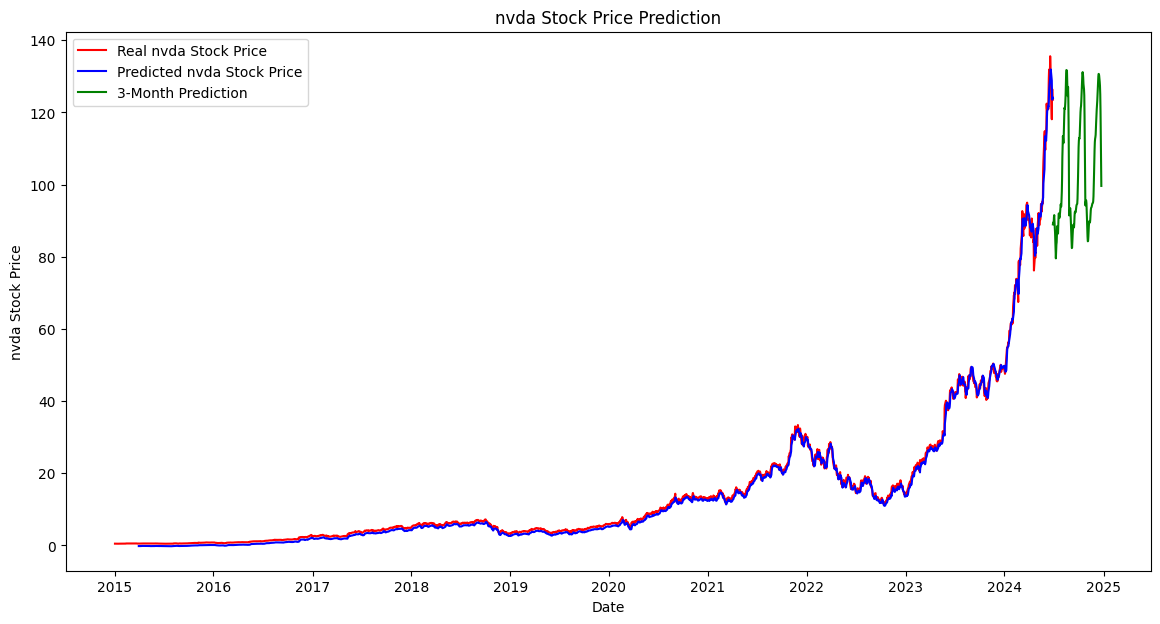

RMSE: 1.1179167981212124


[*********************100%%**********************]  1 of 1 completed

Is the series stationary? No
Epoch 1/50


66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0380 - val_loss: 0.0013
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0030 - val_loss: 9.5651e-04
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0025 - val_loss: 0.0039
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0019 - val_loss: 7.4567e-04
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0021 - val_loss: 7.1715e-04
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0018 - val_loss: 6.9728e-04
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0016 - val_loss: 5.5117e-04
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0015 - val_loss: 6.9095e-04
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/ste

73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━

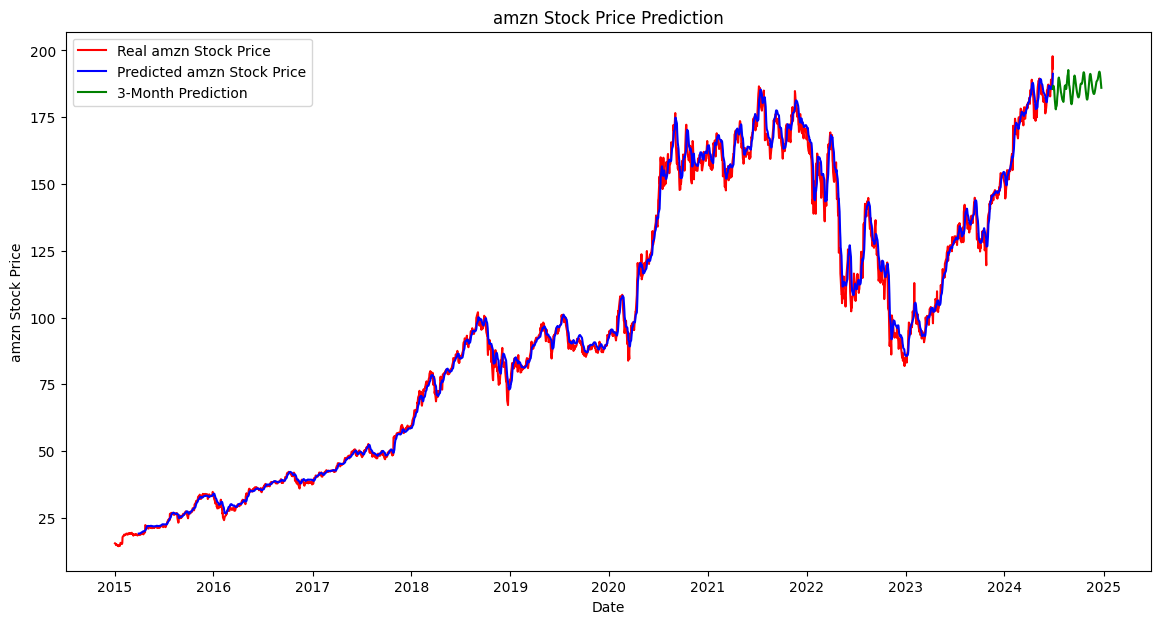

RMSE: 3.4500582140795117


[*********************100%%**********************]  1 of 1 completed


Is the series stationary? No
Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0150 - val_loss: 0.0030
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0010 - val_loss: 0.0073
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0011 - val_loss: 7.3541e-04
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 9.3770e-04 - val_loss: 0.0019
Epoch 12/50
66/66 ━━━━━━━━

73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━

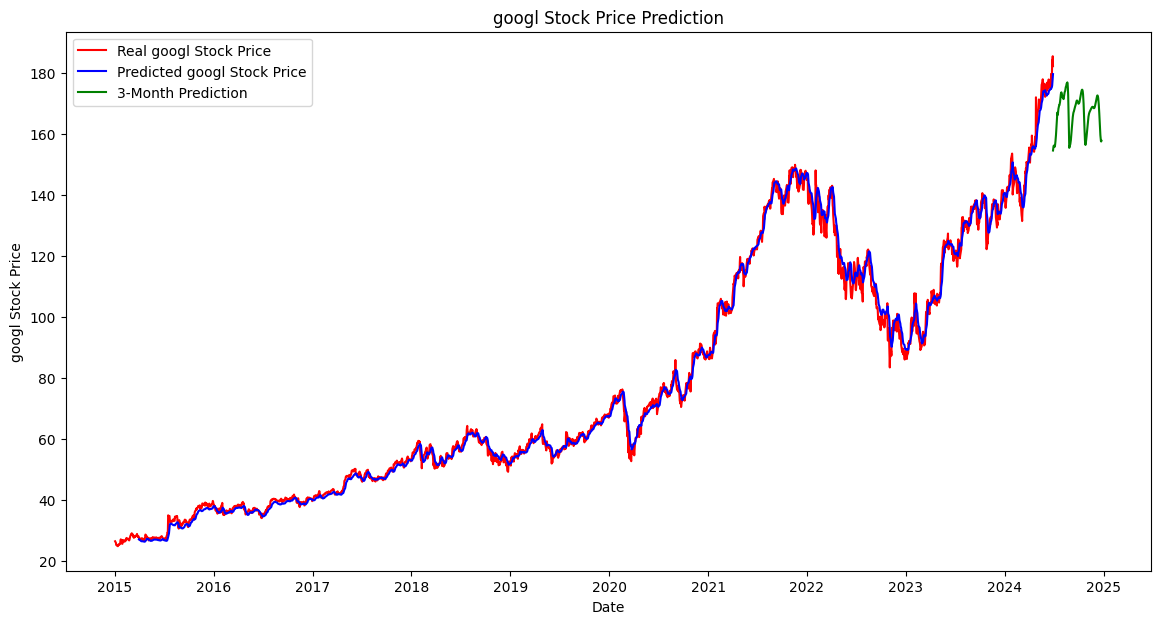

RMSE: 2.5714754294245923


[*********************100%%**********************]  1 of 1 completed


Is the series stationary? No
Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - loss: 0.0115 - val_loss: 0.0032
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - loss: 0.0012 - val_loss: 0.0052
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - loss: 0.0014 - val_loss: 9.7520e-04
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - loss: 0.0012 - val_loss: 8.8414e-04
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - loss: 8.7251e-04 - val_loss: 0.0039
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - loss: 9.8542e-04 - val_loss: 0.0013
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - loss: 8.4461e-04 - val_loss: 0.0012
Epoch 9/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - loss: 7.7813e-04 - val_loss: 0.0031
Epoch 10/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - loss: 7.2776e-04 - val_loss: 8.9439e-04
Epoch 11/100
131/131 ━━━━━━━━━━━━━━━━━

73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━

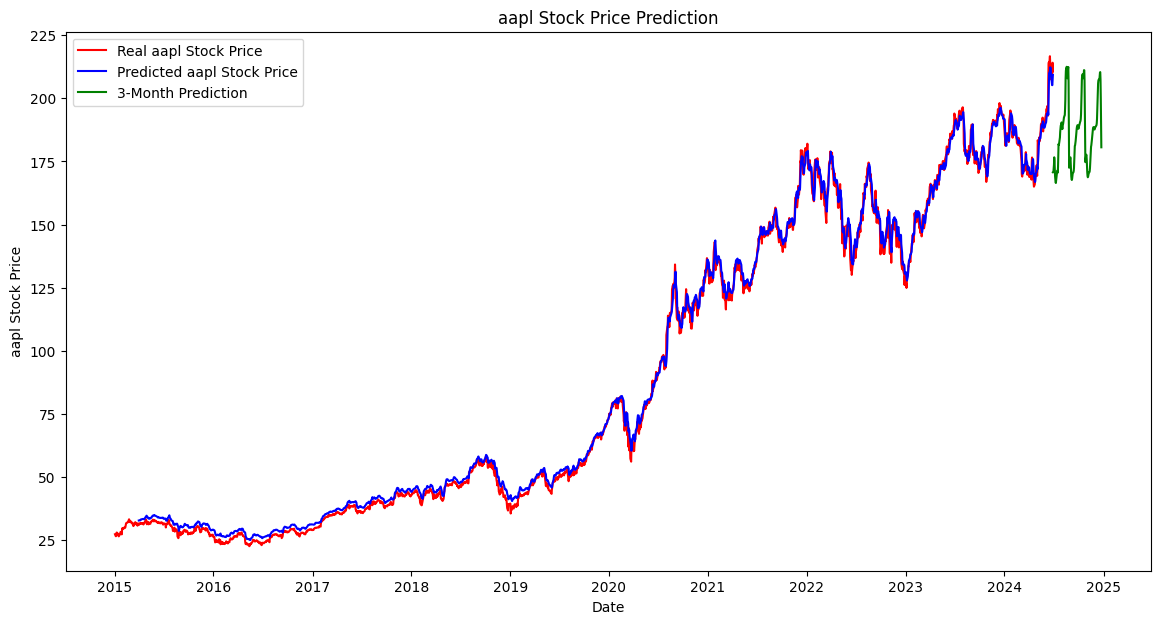

RMSE: 2.6709328155087624


In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, Input, Bidirectional
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

def load_data(ticker, start_date):
    data = yf.download(ticker, start=start_date)
    data.index = pd.to_datetime(data.index)
    closing_prices = data['Close'].values.reshape(-1, 1)
    return data, closing_prices

def check_stationarity(data, threshold=0.05):
    result = adfuller(data)
    p_value = result[1]
    return p_value < threshold

def difference_data(data, interval=1):
    diff = []
    for i in range(interval, len(data)):
        diff.append(data[i] - data[i - interval])
    return np.array(diff)

def inverse_difference(last_ob, value):
    return value + last_ob

def create_lagged_features(data, lookback_period):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lookback_period+1)]
    df_lagged = pd.concat(columns, axis=1)
    df_lagged.columns = ['lag_{}'.format(i) for i in range(1, lookback_period+1)]
    df_lagged.dropna(inplace=True)
    return df_lagged.values

def preprocess_data(closing_prices, lookback_period, stationary=False):
    if stationary:
        closing_prices = difference_data(closing_prices.flatten())
        closing_prices = closing_prices.reshape(-1, 1)

    sc = MinMaxScaler(feature_range=(0, 1))
    scaled_prices = sc.fit_transform(closing_prices)
    
    lagged_features = create_lagged_features(scaled_prices, lookback_period)
    X, y = lagged_features, scaled_prices[lookback_period:]
    
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, sc, scaled_prices

def build_model(input_shape, units, dropout):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Bidirectional(LSTM(units=units, return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(units=units, return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(units=units, return_sequences=False)))
    model.add(Dropout(dropout))
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_model(model, X, y, batch_size, epochs):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])
    return model

def predict_future(model, sc, lookback_period, scaled_prices, forecast_days):
    future_predictions = []
    last_lookback_period = scaled_prices[-lookback_period:]
    current_input = last_lookback_period.reshape((1, lookback_period, 1))

    for _ in range(forecast_days):
        future_price = model.predict(current_input)
        future_predictions.append(future_price[0, 0])
        current_input = np.append(current_input[:, 1:, :], future_price.reshape(1, 1, 1), axis=1)

    future_predictions = sc.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_predictions

def plot_predictions(data, closing_prices, predicted_stock_price, future_predictions, ticker):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, closing_prices, color='red', label=f'Real {ticker} Stock Price')
    plt.plot(data.index[lookback_period:], predicted_stock_price, color='blue', label=f'Predicted {ticker} Stock Price')
    plt.plot(pd.date_range(start=data.index[-1], periods=len(future_predictions)), future_predictions, color='green', label='3-Month Prediction')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel(f'{ticker} Stock Price')
    plt.legend()
    plt.show()

def main(ticker, start_date, lookback_period, units, dropout, batch_size, epochs, forecast_days):
    data, closing_prices = load_data(ticker, start_date)
    
    # Check for stationarity
    stationary = check_stationarity(closing_prices.flatten())
    print(f"Is the series stationary? {'Yes' if stationary else 'No'}")
    
    X, y, sc, scaled_prices = preprocess_data(closing_prices, lookback_period, stationary)
    
    # Uncomment the following lines if you want to train the model again
    #model = build_model((X.shape[1], 1), units, dropout)
    #model = train_model(model, X, y, batch_size, epochs)
    #model.save(f'{ticker}_lstm_model.h5')
    #with open(f'{ticker}_scaler.pkl', 'wb') as f:
    #    pickle.dump(sc, f)
    
    model = load_model(f'{ticker}_lstm_model.h5')
    with open(f'{ticker}_lstm_model.h5', 'rb') as f:
        sc = pickle.load(f)

    predicted_stock_price = model.predict(X)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    
    if stationary:
        # Reconstruct the predicted stock prices if differenced
        predicted_stock_price = np.array([inverse_difference(closing_prices[i], predicted_stock_price[i]) for i in range(len(predicted_stock_price))])
    
    future_predictions = predict_future(model, sc, lookback_period, scaled_prices, forecast_days)
    
    if stationary:
        last_ob = closing_prices[-1]
        future_predictions = [inverse_difference(last_ob, future_predictions[i]) for i in range(len(future_predictions))]
    
    plot_predictions(data, closing_prices, predicted_stock_price, future_predictions, ticker)
    
    rmse = np.sqrt(mean_squared_error(closing_prices[lookback_period:], predicted_stock_price))
    print(f'RMSE: {rmse}')

# Parameters for NVDA
ticker_nvda = 'nvda'
start_date_nvda = '2015-01-01'
lookback_period_nvda = 60
units_nvda = 100
dropout_nvda = 0.2
batch_size_nvda = 16
epochs_nvda = 100
forecast_days_nvda = 180

main(ticker_nvda, start_date_nvda, lookback_period_nvda, units_nvda, dropout_nvda, batch_size_nvda, epochs_nvda, forecast_days_nvda)

# Parameters for AMZN
ticker_amzn = 'amzn'
start_date_amzn = '2015-01-01'
lookback_period_amzn = 60
units_amzn = 50
dropout_amzn = 0.2
batch_size_amzn = 32
epochs_amzn = 50
forecast_days_amzn = 180

main(ticker_amzn, start_date_amzn, lookback_period_amzn, units_amzn, dropout_amzn, batch_size_amzn, epochs_amzn, forecast_days_amzn)

# Parameters for GOOGL
ticker_googl = 'googl'
start_date_googl = '2015-01-01'
lookback_period_googl = 60
units_googl = 50
dropout_googl = 0.2
batch_size_googl = 32
epochs_googl = 50
forecast_days_googl = 180

main(ticker_googl, start_date_googl, lookback_period_googl, units_googl, dropout_googl, batch_size_googl, epochs_googl, forecast_days_googl)

# Parameters for AAPL
ticker_aapl = 'aapl'
start_date_aapl = '2015-01-01'
lookback_period_aapl = 60
units_aapl = 100
dropout_aapl = 0.2
batch_size_aapl = 16
epochs_aapl = 100
forecast_days_aapl = 180

main(ticker_aapl, start_date_aapl, lookback_period_aapl, units_aapl, dropout_aapl, batch_size_aapl, epochs_aapl, forecast_days_aapl)


76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━

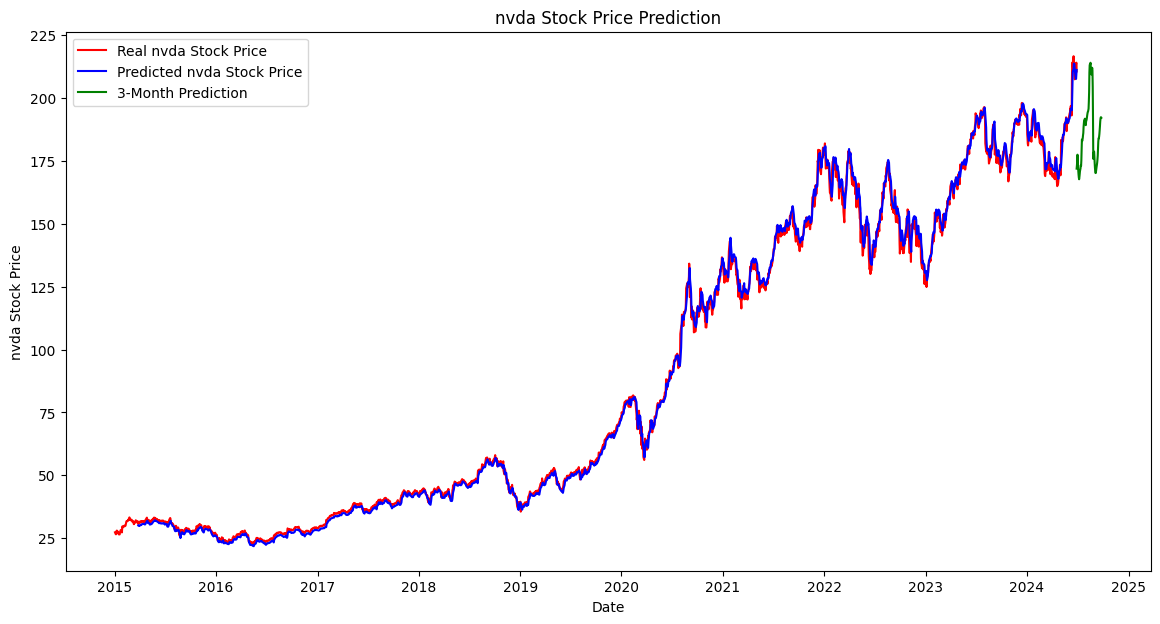

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pickle
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

def load_lstm(ticker):
    # Load the pre-trained LSTM model and scaler
    model = load_model(f'{ticker}_lstm_model.h5')
    with open(f'{ticker}_scaler.pkl', 'rb') as f:
        sc = pickle.load(f)

    return model, sc

def fit_lstm(sc, lookback_period):
    def check_stationarity(data, threshold=0.05):
        result = adfuller(data)
        p_value = result[1]
        return p_value < threshold

    def difference_data(data, interval=1):
        diff = []
        for i in range(interval, len(data)):
            diff.append(data[i] - data[i - interval])
        return np.array(diff)

    def create_lagged_features(data, lookback_period):
        df = pd.DataFrame(data)
        columns = [df.shift(i) for i in range(1, lookback_period+1)]
        df_lagged = pd.concat(columns, axis=1)
        df_lagged.columns = ['lag_{}'.format(i) for i in range(1, lookback_period+1)]
        df_lagged.dropna(inplace=True)
        return df_lagged.values

    def preprocess_data(sc, closing_prices, lookback_period, stationary=False):
        if stationary:
            closing_prices = difference_data(closing_prices.flatten())
            closing_prices = closing_prices.reshape(-1, 1)

        scaled_prices = sc.fit_transform(closing_prices)
        
        lagged_features = create_lagged_features(scaled_prices, lookback_period)
        X, y = lagged_features, scaled_prices[lookback_period:]
        
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))
        return X, y, scaled_prices

    closing_prices = data['Close'].values.reshape(-1, 1)

    # Determine if data is stationary
    stationary = check_stationarity(closing_prices.flatten())

    # Preprocess data
    train_returns, test_returns, scaled_prices = preprocess_data(sc, closing_prices, lookback_period, stationary)

    return closing_prices, train_returns, scaled_prices, stationary


def forecast_lstm(model, sc, closing_prices, train_returns, scaled_prices, stationary, lookback_period, forecast_days=90):
    def inverse_difference(last_ob, value):
        return value + last_ob

    def predict_future(model, sc, lookback_period, scaled_prices, forecast_days):
        future_predictions = []
        last_lookback_period = scaled_prices[-lookback_period:]
        current_input = last_lookback_period.reshape((1, lookback_period, 1))

        for _ in range(forecast_days):
            future_price = model.predict(current_input)
            future_predictions.append(future_price[0, 0])
            current_input = np.append(current_input[:, 1:, :], future_price.reshape(1, 1, 1), axis=1)

        future_predictions = sc.inverse_transform(np.array(future_predictions).reshape(-1, 1))
        return future_predictions

    # Predicting the stock prices
    predicted_stock_price = model.predict(train_returns)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)

    if stationary:
        # Reconstruct the predicted stock prices if differenced
        predicted_stock_price = np.array([inverse_difference(closing_prices[i], predicted_stock_price[i]) for i in range(len(predicted_stock_price))])

    future_predictions = predict_future(model, sc, lookback_period, scaled_prices, forecast_days)

    if stationary:
        last_ob = closing_prices[-1]
        future_predictions = [inverse_difference(last_ob, future_predictions[i]) for i in range(len(future_predictions))]

    return predicted_stock_price, future_predictions

def plot_predictions(data, closing_prices, predicted_stock_price, future_predictions, ticker):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, closing_prices, color='red', label=f'Real {ticker} Stock Price')
    plt.plot(data.index[lookback_period:], predicted_stock_price, color='blue', label=f'Predicted {ticker} Stock Price')
    plt.plot(pd.date_range(start=data.index[-1], periods=len(future_predictions)), future_predictions, color='green', label='3-Month Prediction')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel(f'{ticker} Stock Price')
    plt.legend()
    plt.show()

# Example usage
ticker = 'nvda'
start_date = '2015-01-01'
lookback_period = 60
forecast_days = 90

model, sc = load_lstm(ticker)
closing_prices, train_returns, scaled_prices, stationary = fit_lstm(data, sc, lookback_period)
predicted_stock_price, future_predictions = forecast_lstm(model, sc, closing_prices, train_returns, scaled_prices, stationary, lookback_period, forecast_days)
plot_predictions(data, closing_prices, predicted_stock_price, future_predictions, ticker)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, Input, Bidirectional
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

def load_data(ticker, start_date):
    data = yf.download(ticker, start=start_date)
    data.index = pd.to_datetime(data.index)
    closing_prices = data['Close'].values.reshape(-1, 1)
    return data, closing_prices

def check_stationarity(data, threshold=0.05):
    result = adfuller(data)
    p_value = result[1]
    return p_value < threshold

def difference_data(data, interval=1):
    diff = []
    for i in range(interval, len(data)):
        diff.append(data[i] - data[i - interval])
    return np.array(diff)

def inverse_difference(last_ob, value):
    return value + last_ob

def create_lagged_features(data, lookback_period):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lookback_period+1)]
    df_lagged = pd.concat(columns, axis=1)
    df_lagged.columns = ['lag_{}'.format(i) for i in range(1, lookback_period+1)]
    df_lagged.dropna(inplace=True)
    return df_lagged.values

def preprocess_data(closing_prices, lookback_period, stationary=False):
    if stationary:
        closing_prices = difference_data(closing_prices.flatten())
        closing_prices = closing_prices.reshape(-1, 1)

    sc = MinMaxScaler(feature_range=(0, 1))
    scaled_prices = sc.fit_transform(closing_prices)
    
    lagged_features = create_lagged_features(scaled_prices, lookback_period)
    X, y = lagged_features, scaled_prices[lookback_period:]
    
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, sc, scaled_prices

def build_model(input_shape, units, dropout):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Bidirectional(LSTM(units=units, return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(units=units, return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(units=units, return_sequences=False)))
    model.add(Dropout(dropout))
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_model(model, X, y, batch_size, epochs):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])
    return model

def predict_future(model, sc, lookback_period, scaled_prices, forecast_days):
    future_predictions = []
    last_lookback_period = scaled_prices[-lookback_period:]
    current_input = last_lookback_period.reshape((1, lookback_period, 1))

    for _ in range(forecast_days):
        future_price = model.predict(current_input)
        future_predictions.append(future_price[0, 0])
        current_input = np.append(current_input[:, 1:, :], future_price.reshape(1, 1, 1), axis=1)

    future_predictions = sc.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_predictions

def plot_predictions(data, closing_prices, predicted_stock_price, future_predictions, ticker, lookback_period):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, closing_prices, color='red', label=f'Real {ticker} Stock Price')
    plt.plot(data.index[lookback_period:], predicted_stock_price, color='blue', label=f'Predicted {ticker} Stock Price')
    plt.plot(pd.date_range(start=data.index[-1], periods=len(future_predictions)), future_predictions, color='green', label='3-Month Prediction')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel(f'{ticker} Stock Price')
    plt.legend()
    plt.show()

def main(ticker, start_date, lookback_period, units, dropout, batch_size, epochs, forecast_days):
    data, closing_prices = load_data(ticker, start_date)
    
    # Check for stationarity
    stationary = check_stationarity(closing_prices.flatten())
    print(f"Is the series stationary? {'Yes' if stationary else 'No'}")
    
    X, y, sc, scaled_prices = preprocess_data(closing_prices, lookback_period, stationary)
    
    # Uncomment the following lines if you want to train the model again
    model = build_model((X.shape[1], 1), units, dropout)
    model = train_model(model, X, y, batch_size, epochs)
    model.save(f'{ticker}_lstm_model.h5')
    with open(f'{ticker}_scaler.pkl', 'wb') as f:
        pickle.dump(sc, f)
    
    #model = load_model(f'{ticker}_lstm_model.h5')
    #with open(f'{ticker}_lstm_model.h5', 'rb') as f:
    #    sc = pickle.load(f)

    predicted_stock_price = model.predict(X)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    
    if stationary:
        # Reconstruct the predicted stock prices if differenced
        predicted_stock_price = np.array([inverse_difference(closing_prices[i], predicted_stock_price[i]) for i in range(len(predicted_stock_price))])
    
    future_predictions = predict_future(model, sc, lookback_period, scaled_prices, forecast_days)
    
    if stationary:
        last_ob = closing_prices[-1]
        future_predictions = [inverse_difference(last_ob, future_predictions[i]) for i in range(len(future_predictions))]
    
    plot_predictions(data, closing_prices, predicted_stock_price, future_predictions, ticker, lookback_period)
    
    rmse = np.sqrt(mean_squared_error(closing_prices[lookback_period:], predicted_stock_price))
    print(f'RMSE: {rmse}')

# Parameters for ASML
ticker_asml = 'ASML'
start_date_asml = '2015-01-01'
lookback_period_asml = 60
units_asml = 100
dropout_asml = 0.2
batch_size_asml = 32
epochs_asml = 100
forecast_days_asml = 90

main(ticker_asml, start_date_asml, lookback_period_asml, units_asml, dropout_asml, batch_size_asml, epochs_asml, forecast_days_asml)

# Parameters for TSLA
ticker_tsla = 'TSLA'
start_date_tsla = '2015-01-01'
lookback_period_tsla = 60
units_tsla = 100
dropout_tsla = 0.2
batch_size_tsla = 32
epochs_tsla = 100
forecast_days_tsla = 90

main(ticker_tsla, start_date_tsla, lookback_period_tsla, units_tsla, dropout_tsla, batch_size_tsla, epochs_tsla, forecast_days_tsla)

# Parameters for SMCI
ticker_smci = 'SMCI'
start_date_smci = '2015-01-01'
lookback_period_smci = 60
units_smci = 100
dropout_smci = 0.3
batch_size_smci = 32
epochs_smci = 100
forecast_days_smci = 90

main(ticker_smci, start_date_smci, lookback_period_smci, units_smci, dropout_smci, batch_size_smci, epochs_smci, forecast_days_smci)

# Parameters for RIOT
ticker_riot = 'RIOT'
start_date_riot = '2015-01-01'
lookback_period_riot = 60
units_riot = 50
dropout_riot = 0.3
batch_size_riot = 32
epochs_riot = 50
forecast_days_riot = 90

main(ticker_riot, start_date_riot, lookback_period_riot, units_riot, dropout_riot, batch_size_riot, epochs_riot, forecast_days_riot)

# Parameters for MSFT
ticker_msft = 'MSFT'
start_date_msft = '2015-01-01'
lookback_period_msft = 60
units_msft = 100
dropout_msft = 0.2
batch_size_msft = 32
epochs_msft = 100
forecast_days_msft = 90

main(ticker_msft, start_date_msft, lookback_period_msft, units_msft, dropout_msft, batch_size_msft, epochs_msft, forecast_days_msft)

# Parameters for NFLX
ticker_nflx = 'NFLX'
start_date_nflx = '2015-01-01'
lookback_period_nflx = 60
units_nflx = 100
dropout_nflx = 0.2
batch_size_nflx = 32
epochs_nflx = 100
forecast_days_nflx = 90

main(ticker_nflx, start_date_nflx, lookback_period_nflx, units_nflx, dropout_nflx, batch_size_nflx, epochs_nflx, forecast_days_nflx)

# Parameters for MSTR
ticker_mstr = 'MSTR'
start_date_mstr = '2015-01-01'
lookback_period_mstr = 60
units_mstr = 100
dropout_mstr = 0.3
batch_size_mstr = 32
epochs_mstr = 100
forecast_days_mstr = 90

main(ticker_mstr, start_date_mstr, lookback_period_mstr, units_mstr, dropout_mstr, batch_size_mstr, epochs_mstr, forecast_days_mstr)


[*********************100%%**********************]  1 of 1 completed


Is the series stationary? Yes
Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 233ms/step - loss: 0.0483 - val_loss: 0.0012
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 23s 339ms/step - loss: 0.0031 - val_loss: 8.3969e-04
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 28s 419ms/step - loss: 0.0027 - val_loss: 8.9811e-04
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 27s 400ms/step - loss: 0.0025 - val_loss: 9.5506e-04
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 28s 415ms/step - loss: 0.0026 - val_loss: 8.2634e-04
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 27s 397ms/step - loss: 0.0025 - val_loss: 8.7453e-04
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 26s 389ms/step - loss: 0.0029 - val_loss: 8.5974e-04
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 28s 422ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 28s 415ms/step - loss: 0.0023 - val_loss: 8.9448e-04
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 24s 355ms/step - loss: 0.0028 - val_loss: 8.5661e-04
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 24s 360ms/step - 

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/var/folders/ps/6sp6yv3x0ls96dst6g5f8sn00000gp/T/ipykernel_62013/3930204626.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_stock_price = np.array([inverse_difference(closing_prices[i], predicted_stock_price[i]) for i in range(len(predicted_stock_price))])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

/var/folders/ps/6sp6yv3x0ls96dst6g5f8sn00000gp/T/ipykernel_62013/3930204626.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_ob = closing_prices[-1]


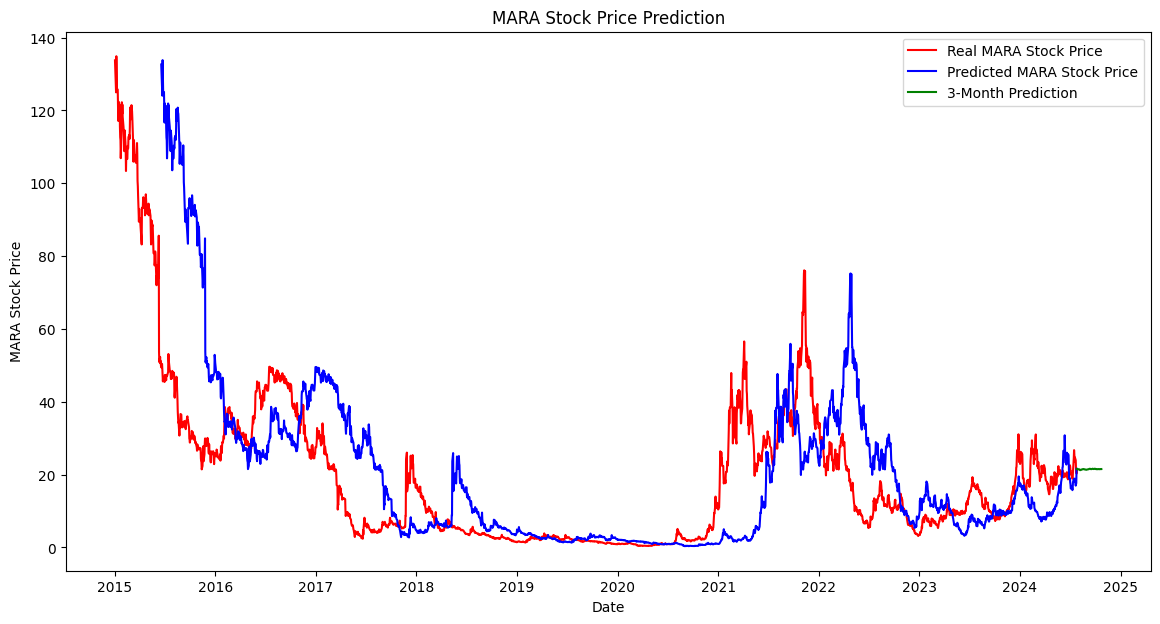

RMSE: 19.646817062473392


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, Input, Bidirectional
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

def load_data(ticker, start_date):
    data = yf.download(ticker, start_date)
    data.index = pd.to_datetime(data.index)
    data = data.asfreq('B')  # 'B' indicates business days
    data = data.ffill().dropna()  # Forward fill NaN values and drop remaining NaNs
    closing_prices = data['Close']
    return data, closing_prices

def check_stationarity(data, threshold=0.05):
    result = adfuller(data)
    p_value = result[1]
    return p_value < threshold

def difference_data(data, interval=1):
    diff = []
    for i in range(interval, len(data)):
        diff.append(data[i] - data[i - interval])
    return np.array(diff)

def inverse_difference(last_ob, value):
    return value + last_ob

def create_lagged_features(data, lookback_period):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lookback_period+1)]
    df_lagged = pd.concat(columns, axis=1)
    df_lagged.columns = ['lag_{}'.format(i) for i in range(1, lookback_period+1)]
    df_lagged.dropna(inplace=True)
    return df_lagged.values

def preprocess_data(closing_prices, lookback_period, stationary=False):
    if stationary:
        closing_prices = difference_data(closing_prices.values.flatten())
        closing_prices = closing_prices.reshape(-1, 1)

    sc = MinMaxScaler(feature_range=(0, 1))
    scaled_prices = sc.fit_transform(closing_prices)
    
    lagged_features = create_lagged_features(scaled_prices, lookback_period)
    X, y = lagged_features, scaled_prices[lookback_period:]
    
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, sc, scaled_prices

def build_model(input_shape, units, dropout):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Bidirectional(LSTM(units=units, return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(units=units, return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(units=units, return_sequences=False)))
    model.add(Dropout(dropout))
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_model(model, X, y, batch_size, epochs):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])
    return model

def predict_future(model, sc, lookback_period, scaled_prices, forecast_days):
    future_predictions = []
    last_lookback_period = scaled_prices[-lookback_period:]
    current_input = last_lookback_period.reshape((1, lookback_period, 1))

    for _ in range(forecast_days):
        future_price = model.predict(current_input)
        future_predictions.append(future_price[0, 0])
        current_input = np.append(current_input[:, 1:, :], future_price.reshape(1, 1, 1), axis=1)

    future_predictions = np.array(future_predictions).reshape(-1, 1)  # Ensure it's a NumPy array
    future_predictions = sc.inverse_transform(future_predictions)
    return future_predictions

def plot_predictions(data, closing_prices, predicted_stock_price, future_predictions, ticker, lookback_period):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, closing_prices, color='red', label=f'Real {ticker} Stock Price')
    plt.plot(data.index[lookback_period:lookback_period + len(predicted_stock_price)], predicted_stock_price, color='blue', label=f'Predicted {ticker} Stock Price')
    plt.plot(pd.date_range(start=data.index[-1], periods=len(future_predictions)), future_predictions, color='green', label='3-Month Prediction')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel(f'{ticker} Stock Price')
    plt.legend()
    plt.show()

def main(ticker, start_date, lookback_period, units, dropout, batch_size, epochs, forecast_days):
    data, closing_prices = load_data(ticker, start_date)
        
    # Check for stationarity
    stationary = check_stationarity(closing_prices.values.flatten())
    print(f"Is the series stationary? {'Yes' if stationary else 'No'}")
    
    X, y, sc, scaled_prices = preprocess_data(closing_prices, lookback_period, stationary)
        
    # Uncomment the following lines if you want to train the model again
    model = build_model((X.shape[1], 1), units, dropout)
    model = train_model(model, X, y, batch_size, epochs)
    model.save(f'{ticker}_lstm_model.h5')
    with open(f'{ticker}_scaler.pkl', 'wb') as f:
        pickle.dump(sc, f)
    
    # model = load_model(f'{ticker}_lstm_model.h5')
    # with open(f'{ticker}_scaler.pkl', 'rb') as f:
    #     sc = pickle.load(f)

    predicted_stock_price = model.predict(X)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
        
    if stationary:
        # Reconstruct the predicted stock prices if differenced
        predicted_stock_price = np.array([inverse_difference(closing_prices[i], predicted_stock_price[i]) for i in range(len(predicted_stock_price))])
    
    future_predictions = predict_future(model, sc, lookback_period, scaled_prices, forecast_days)
    
    if stationary:
        last_ob = closing_prices[-1]
        future_predictions = [inverse_difference(last_ob, future_predictions[i]) for i in range(len(future_predictions))]
    
    plot_predictions(data, closing_prices, predicted_stock_price, future_predictions, ticker, lookback_period)
    
    min_length = min(len(closing_prices[lookback_period:]), len(predicted_stock_price))
    rmse = np.sqrt(mean_squared_error(closing_prices[lookback_period:lookback_period + min_length], predicted_stock_price[:min_length]))
    print(f'RMSE: {rmse}')

# Parameters for MARA
ticker_mara = 'MARA'
start_date_mara = '2015-01-01'
lookback_period_mara = 60
units_mara = 50
dropout_mara = 0.3
batch_size_mara = 32
epochs_mara = 50
forecast_days_mara = 90

main(ticker_mara, start_date_mara, lookback_period_mara, units_mara, dropout_mara, batch_size_mara, epochs_mara, forecast_days_mara)


[*********************100%%**********************]  1 of 1 completed


Is the series stationary? Yes
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━

ValueError: x and y must have same first dimension, but have shapes (2347,) and (2346, 1)

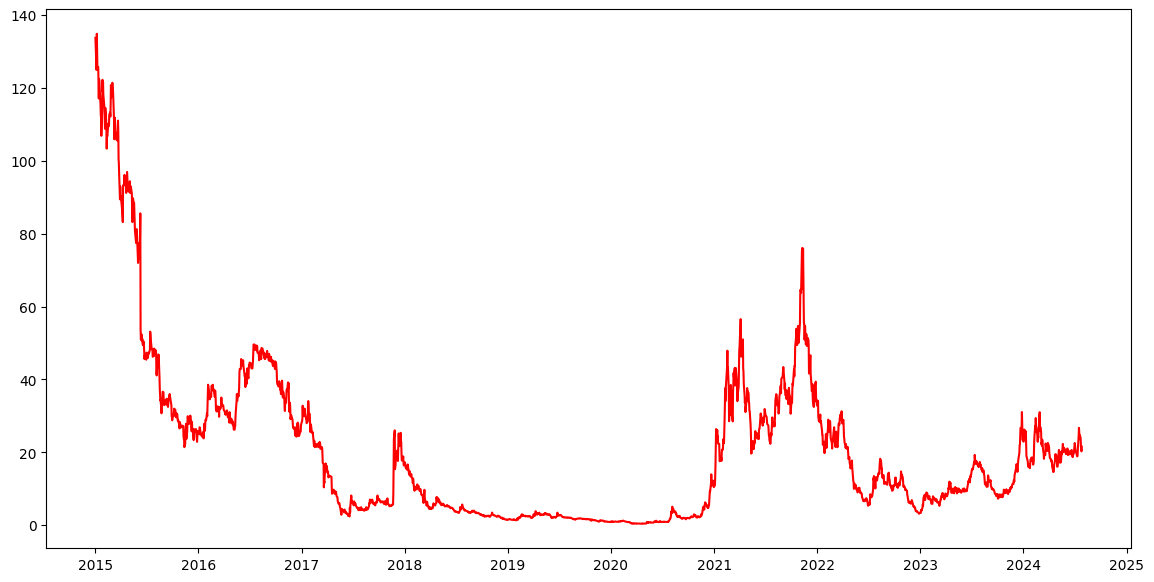

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, Input, Bidirectional
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

def load_data(ticker, start_date):
    data = yf.download(ticker, start=start_date)
    data.index = pd.to_datetime(data.index)
    closing_prices = data['Close'].values.reshape(-1, 1)
    return data, closing_prices

def check_stationarity(data, threshold=0.05):
    result = adfuller(data)
    p_value = result[1]
    return p_value < threshold

def difference_data(data, interval=1):
    diff = []
    for i in range(interval, len(data)):
        diff.append(data[i] - data[i - interval])
    return np.array(diff)

def inverse_difference(last_ob, value):
    return value + last_ob

def create_lagged_features(data, lookback_period):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lookback_period+1)]
    df_lagged = pd.concat(columns, axis=1)
    df_lagged.columns = ['lag_{}'.format(i) for i in range(1, lookback_period+1)]
    df_lagged.dropna(inplace=True)
    return df_lagged.values

def preprocess_data(closing_prices, lookback_period, sc, stationary=False):
    if stationary:
        closing_prices = difference_data(closing_prices.flatten())
        closing_prices = closing_prices.reshape(-1, 1)

    #sc = MinMaxScaler(feature_range=(0, 1))
    scaled_prices = sc.fit_transform(closing_prices)
    
    lagged_features = create_lagged_features(scaled_prices, lookback_period)
    X, y = lagged_features, scaled_prices[lookback_period:]
    
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaled_prices

def build_model(input_shape, units, dropout):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Bidirectional(LSTM(units=units, return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(units=units, return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(units=units, return_sequences=False)))
    model.add(Dropout(dropout))
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_model(model, X, y, batch_size, epochs):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])
    return model

def predict_future(model, sc, lookback_period, scaled_prices, forecast_days):
    future_predictions = []
    last_lookback_period = scaled_prices[-lookback_period:]
    current_input = last_lookback_period.reshape((1, lookback_period, 1))

    for _ in range(forecast_days):
        future_price = model.predict(current_input)
        future_predictions.append(future_price[0, 0])
        current_input = np.append(current_input[:, 1:, :], future_price.reshape(1, 1, 1), axis=1)

    future_predictions = sc.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_predictions

def plot_predictions(data, closing_prices, predicted_stock_price, future_predictions, ticker, lookback_period):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, closing_prices, color='red', label=f'Real {ticker} Stock Price')
    plt.plot(data.index[lookback_period:], predicted_stock_price, color='blue', label=f'Predicted {ticker} Stock Price')
    plt.plot(pd.date_range(start=data.index[-1], periods=len(future_predictions)), future_predictions, color='green', label='3-Month Prediction')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel(f'{ticker} Stock Price')
    plt.legend()
    plt.show()

def main(ticker, start_date, lookback_period, units, dropout, batch_size, epochs, forecast_days):
    data, closing_prices = load_data(ticker, start_date)
    
    # Check for stationarity
    stationary = check_stationarity(closing_prices.flatten())
    print(f"Is the series stationary? {'Yes' if stationary else 'No'}")
    
    #X, y, sc, scaled_prices = preprocess_data(closing_prices, lookback_period, stationary)
    
    # Uncomment the following lines if you want to train the model again
    #model = build_model((X.shape[1], 1), units, dropout)
    #model = train_model(model, X, y, batch_size, epochs)
    #model.save(f'{ticker}_lstm_model.h5')
    #with open(f'{ticker}_scaler.pkl', 'wb') as f:
    #    pickle.dump(sc, f)
    
    model = load_model(f'{ticker}_lstm_model.h5')
    with open(f'{ticker}_scaler.pkl', 'rb') as f:
        sc = pickle.load(f)

    X, y, scaled_prices = preprocess_data(closing_prices, lookback_period, sc, stationary)

    predicted_stock_price = model.predict(X)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    
    if stationary:
        # Reconstruct the predicted stock prices if differenced
        predicted_stock_price = np.array([inverse_difference(closing_prices[i], predicted_stock_price[i]) for i in range(len(predicted_stock_price))])
    
    future_predictions = predict_future(model, sc, lookback_period, scaled_prices, forecast_days)
    
    if stationary:
        last_ob = closing_prices[-1]
        future_predictions = [inverse_difference(last_ob, future_predictions[i]) for i in range(len(future_predictions))]
    
    plot_predictions(data, closing_prices, predicted_stock_price, future_predictions, ticker, lookback_period)
    
    rmse = np.sqrt(mean_squared_error(closing_prices[lookback_period:], predicted_stock_price))
    print(f'RMSE: {rmse}')

# Parameters for MARA
ticker_mara = 'MARA'
start_date_mara = '2015-01-01'
lookback_period_mara = 60
units_mara = 50
dropout_mara = 0.3
batch_size_mara = 32
epochs_mara = 50
forecast_days_mara = 90

main(ticker_mara, start_date_mara, lookback_period_mara, units_mara, dropout_mara, batch_size_mara, epochs_mara, forecast_days_mara)


[*********************100%%**********************]  1 of 1 completed


Is the series stationary? Yes
Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0666 - val_loss: 0.0012
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0049 - val_loss: 8.6624e-04
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0044 - val_loss: 0.0015
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0043 - val_loss: 0.0010
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0039 - val_loss: 8.8224e-04
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0036 - val_loss: 0.0010
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0038 - val_loss: 9.3037e-04
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0040 - val_loss: 9.4512e-04
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0030 - val_loss: 8.9016e-04
Epoch 12/50
6

Length of closing_prices: 2407
Length of scaled_prices: 2407
Shape of X: (2347, 60, 1)
Shape of y: (2347, 1)
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Length of predicted_stock_price: 2347
Length of data.index[lookback_period:]: 2347
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━

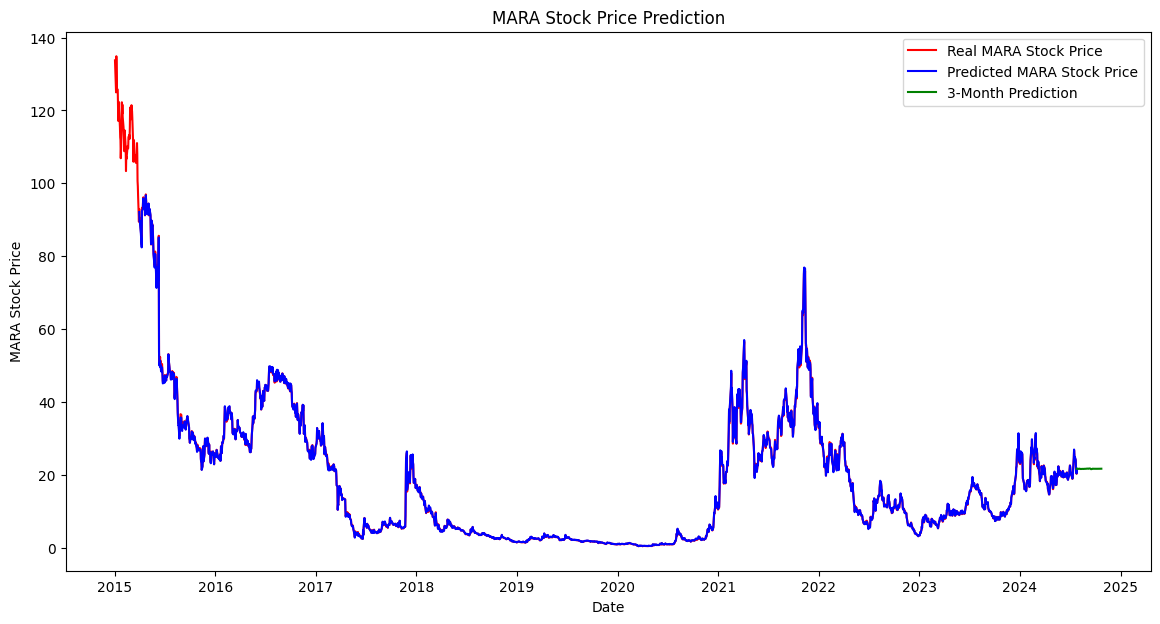

RMSE: 0.19550537155055023


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, Input, Bidirectional
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

def load_data(ticker, start_date):
    data = yf.download(ticker, start=start_date)
    data.index = pd.to_datetime(data.index)
    closing_prices = data['Close'].values.reshape(-1, 1)
    return data, closing_prices

def check_stationarity(data, threshold=0.05):
    result = adfuller(data)
    p_value = result[1]
    return p_value < threshold

def difference_data(data, interval=1):
    diff = np.diff(data, n=interval)
    return np.concatenate(([0], diff))

def inverse_difference(last_ob, value):
    return value + last_ob

def create_lagged_features(data, lookback_period):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lookback_period+1)]
    df_lagged = pd.concat(columns, axis=1)
    df_lagged.columns = ['lag_{}'.format(i) for i in range(1, lookback_period+1)]
    df_lagged.dropna(inplace=True)
    return df_lagged.values

def preprocess_data(closing_prices, lookback_period, stationary=False):
    if stationary:
        closing_prices = difference_data(closing_prices.flatten()).reshape(-1, 1)

    sc = MinMaxScaler(feature_range=(0, 1))
    scaled_prices = sc.fit_transform(closing_prices)
    
    lagged_features = create_lagged_features(scaled_prices, lookback_period)
    X, y = lagged_features, scaled_prices[lookback_period:]
    
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, sc, scaled_prices


def build_model(input_shape, units, dropout):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Bidirectional(LSTM(units=units, return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(units=units, return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(units=units, return_sequences=False)))
    model.add(Dropout(dropout))
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_model(model, X, y, batch_size, epochs):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])
    return model

def predict_future(model, sc, lookback_period, scaled_prices, forecast_days):
    future_predictions = []
    last_lookback_period = scaled_prices[-lookback_period:]
    current_input = last_lookback_period.reshape((1, lookback_period, 1))

    for _ in range(forecast_days):
        future_price = model.predict(current_input)
        future_predictions.append(future_price[0, 0])
        current_input = np.append(current_input[:, 1:, :], future_price.reshape(1, 1, 1), axis=1)

    future_predictions = sc.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_predictions

def plot_predictions(data, closing_prices, predicted_stock_price, future_predictions, ticker, lookback_period):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, closing_prices, color='red', label=f'Real {ticker} Stock Price')
    plt.plot(data.index[lookback_period:], predicted_stock_price, color='blue', label=f'Predicted {ticker} Stock Price')
    plt.plot(pd.date_range(start=data.index[-1], periods=len(future_predictions)), future_predictions, color='green', label='3-Month Prediction')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel(f'{ticker} Stock Price')
    plt.legend()
    plt.show()

def main(ticker, start_date, lookback_period, units, dropout, batch_size, epochs, forecast_days):
    data, closing_prices = load_data(ticker, start_date)
    
    # Check for stationarity
    stationary = check_stationarity(closing_prices.flatten())
    print(f"Is the series stationary? {'Yes' if stationary else 'No'}")
    
    """
    model = load_model(f'{ticker}_lstm_model.h5')
    with open(f'{ticker}_scaler.pkl', 'rb') as f:
        sc = pickle.load(f)

    X, y, scaled_prices = preprocess_data(closing_prices, lookback_period, sc, stationary)
    """

    X, y, sc, scaled_prices = preprocess_data(closing_prices, lookback_period, stationary)
        
    # Uncomment the following lines if you want to train the model again
    model = build_model((X.shape[1], 1), units, dropout)
    model = train_model(model, X, y, batch_size, epochs)
    model.save(f'{ticker}_lstm_model.h5')
    with open(f'{ticker}_scaler.pkl', 'wb') as f:
        pickle.dump(sc, f)
    
    # Debug information
    print(f"Length of closing_prices: {len(closing_prices)}")
    print(f"Length of scaled_prices: {len(scaled_prices)}")
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape}")
    
    predicted_stock_price = model.predict(X)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    
    if stationary:
        # Reconstruct the predicted stock prices if differenced
        predicted_stock_price = np.array([inverse_difference(closing_prices[i + lookback_period], predicted_stock_price[i]) for i in range(len(predicted_stock_price))])
    
    # Additional debug information
    print(f"Length of predicted_stock_price: {len(predicted_stock_price)}")
    print(f"Length of data.index[lookback_period:]: {len(data.index[lookback_period:])}")
    
    future_predictions = predict_future(model, sc, lookback_period, scaled_prices, forecast_days)
    
    if stationary:
        last_ob = closing_prices[-1]
        future_predictions = [inverse_difference(last_ob, future_predictions[i]) for i in range(len(future_predictions))]
    
    plot_predictions(data, closing_prices, predicted_stock_price, future_predictions, ticker, lookback_period)
    
    rmse = np.sqrt(mean_squared_error(closing_prices[lookback_period:], predicted_stock_price))
    print(f'RMSE: {rmse}')

# Parameters for MARA
ticker_mara = 'MARA'
start_date_mara = '2015-01-01'
lookback_period_mara = 60
units_mara = 50
dropout_mara = 0.3
batch_size_mara = 32
epochs_mara = 50
forecast_days_mara = 90

main(ticker_mara, start_date_mara, lookback_period_mara, units_mara, dropout_mara, batch_size_mara, epochs_mara, forecast_days_mara)
